In [1]:
import sys
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm # 指数分布の機能を提供するオブジェクト

In [2]:
class Robot(IdealRobot):
    # noise_per_meter:1mあたりの小石の数 noise_std:小石を踏んだときにロボットの向きに発生する雑音の標準偏差
    # expected_stuck_time:スタックするまでの時間の期待値（平均タイム） expected_escape_time:スタックから脱出するまでの時間（平均タイム）
    def __init__(self, pose, agent = None, sensor = None , color = "black",\
                noise_per_meter = 5,noise_std = math.pi/60,\
                bias_rate_stds = (0.1,0.1),\
                expected_stuck_time = 1e100, expected_escape_time = 1e-100):
        
        super().__init__(pose,agent,sensor,color) # super() IdealRobotのinitを呼び出す
        
        self.noise_pdf = expon(scale = 1.0 / (1e-100 + noise_per_meter)) # scale = 1/(λ + 10^-100)
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale = noise_std) # 小石踏んだときの誤差する角度
        self.bias_rate_nu = norm.rvs(loc = 1.0,scale = bias_rate_stds[0]) # 正規分布
        self.bias_rate_omega = norm.rvs(loc = 1.0,scale = bias_rate_stds[1])
        # loc:平均 scale:標準偏差 size:サンプル数
        
        self.stuck_pdf = expon(scale = expected_stuck_time) # 確立密度関数作成
        self.escape_pdf = expon(scale = expected_escape_time)
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False
    
    
    # 速度と角速度にバイアスをかける
    def bias(self,nu,omega):
        return nu * self.bias_rate_nu , omega * self.bias_rate_omega
    
    def noise(self,pose,nu,omega,time_interval):
        # 直進と回転で進む床面の距離
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0: # distance_until_noiseが0かどうか判定
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
    
    def stuck(self,nu,omega,time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
                
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True
        
        return nu * (not self.is_stuck),omega * (not self.is_stuck)
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs) # 速度と角速度を取り出す
        nu, omega = self.bias(nu,omega)      # 取り出したらバイアス
        nu, omega = self.stuck(nu,omega,time_interval)
        self.pose = self.state_transition(nu,omega,time_interval,self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)


<IPython.core.display.Javascript object>


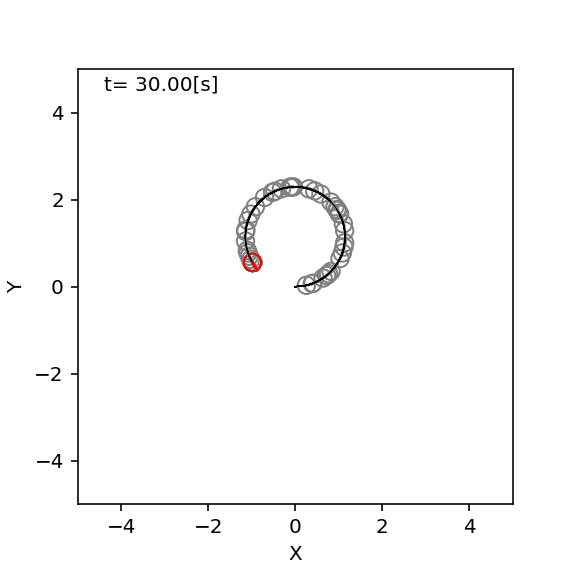

In [4]:
import copy

world = World(30,0.1)
circling = Agent(0.2,10.0 / 180 * math.pi)

for i in range(100):
    r = Robot(np.array([0,0,0]).T, sensor = None, agent = circling, color = "gray",\
                noise_per_meter = 0, bias_rate_stds = (0.0,0.0),\
                expected_stuck_time = 60.0, expected_escape_time = 60.0)
    world.append(r)

r = IdealRobot(np.array([0,0,0]).T,sensor = None,agent = circling,color = "red")
world.append(r)
world.draw()
# 100台のロボットvs１台の理想ロボット
# 多くのロボットはスタックしてリタイア